In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import import_ipynb
import data_extract

In [14]:
%run data_extract.ipynb
def kernel_linear(x1, x2) :
    return np.matmul(np.transpose(x1), x2)
def kernel_polynomial(x1, x2, d=2) :
    return (np.matmul(np.transpose(x1), x2) + float(1)) ** d
def kernel_RBF(x1, x2, sigma=5) :
    return np.exp(- np.sum( np.power((x1 - x2),2) ) / float( 2*(sigma**2) ) )

In [15]:
def objective_function(train_X, train_Y, alpha, b, kernel, input_X) :
    ans = 0
    for i in range(train_X.shape[0]) :
        Val = alpha[i] * train_Y[i] * kernel(train_X[i], input_X)
        ans = ans + Val
    ans = ans + b
    return ans
def simplified_objective_function(train_Y, alpha, b, matrix_kernel, index) :
    ans = 0
    for i in range(train_Y.shape[0]) :
        Val = alpha[i] * train_Y[i] * matrix_kernel[i][index]
        ans = ans + Val
    ans = ans + b
    return ans
def get_eta(i, j, matrix_kernel) :
    return (2 * matrix_kernel[i][j] - matrix_kernel[i][i] - matrix_kernel[j][j])
def get_matrix_kernel(train_X, kernel) :
    matrix_kernel = np.zeros((train_X.shape[0], train_X.shape[0]))
    for i in range(train_X.shape[0]) :
        for j in range(train_X.shape[0]) :
            matrix_kernel[i][j] = kernel(train_X[i], train_X[j])
    return matrix_kernel

In [16]:
matrix_kernel = get_matrix_kernel(train_X, kernel_RBF)

In [17]:
tol = 0.00001
err = 0.00001
C = float(50)
alpha = np.zeros(train_X.shape[0])
b = float(0)
max_passes = 5

In [18]:
#reference-http://cs229.stanford.edu/materials/smo.pdf
passes = 0
while(passes < max_passes) :
    num_changed_alphas = 0
    for i in range(train_X.shape[0]) :
        error_i = simplified_objective_function(train_Y, alpha, b, matrix_kernel, i) - train_Y[i]
        if((train_Y[i] * error_i < float(-1 * tol) and alpha[i] < C) or (train_Y[i] * error_i > tol and alpha[i] > 0)) :
            j = i
            while(j == i) :
                j = np.random.randint(0, train_X.shape[0])
            error_j = simplified_objective_function(train_Y, alpha, b, matrix_kernel, j) - train_Y[j]
            alpha_i_old = alpha[i]
            alpha_j_old = alpha[j]
            if(train_Y[i] != train_Y[j]) :
                L = max(float(0), alpha[j] - alpha[i])
                H = min(C, C + alpha[j] - alpha[i])
            else :
                L = max(0, alpha[i] + alpha[j] - C)
                H = min(C, alpha[i] + alpha[j])
            if(L == H) :
                continue
            eta = get_eta(i, j, matrix_kernel)
            if(eta == 0) :
                continue
            alpha_j_new = alpha_j_old - float((train_Y[j] * (error_i - error_j)) / eta)
            if(alpha_j_new > H) :
                alpha_j_new = H
            if(alpha_j_new < L) :
                alpha_j_new = L
            if(np.abs(alpha_j_new - alpha_j_old) < err) :
                continue
            alpha_i_new = alpha_i_old + (train_Y[i] * train_Y[j] * (alpha_j_old - alpha_j_new))
            alpha[i] = alpha_i_new
            alpha[j] = alpha_j_new
            b1 = b - error_i - (train_Y[i] * (alpha_i_new - alpha_i_old) * matrix_kernel[i][i]) - (train_Y[j] * (alpha_j_new - alpha_j_old) * matrix_kernel[i][j])
            b2 = b - error_j - (train_Y[i] * (alpha_i_new - alpha_i_old) * matrix_kernel[i][j]) - (train_Y[j] * (alpha_j_new - alpha_j_old) * matrix_kernel[j][j])
            if(alpha_i_new > 0 and alpha_i_new < C) :
                b = b1
            elif(alpha_j_new > 0 and alpha_j_new < C) :
                b = b2
            else :
                b = float((b1 + b2) / float(2))  
            num_changed_alphas += 1
    if(num_changed_alphas == 0) :
        passes += 1
    else :
        passes = 0

In [19]:
correct_total = 0
for i in range(train_X.shape[0]) :
    Val = objective_function(train_X, train_Y, alpha, b, kernel_RBF, train_X[i])
    if(Val >= 0 and train_Y[i] == 1) :
        correct_total += 1
    elif(Val < 0 and train_Y[i] == -1) :
        correct_total += 1

In [20]:
print("Accuracy : ", (correct_total / train_X.shape[0]) * 100 )

Accuracy :  100.0


In [21]:
correct_total = 0
for i in range(validation_X.shape[0]) :
    Val = objective_function(train_X, train_Y, alpha, b, kernel_RBF, validation_X[i])
    if(Val >= 0 and validation_Y[i] == 1) :
        correct_total += 1
    elif(Val < 0 and validation_Y[i] == -1) :
        correct_total += 1

In [22]:
print("Accuracy : ", (correct_total / validation_X.shape[0]) * 100 )

Accuracy :  98.49849849849849


In [23]:
correct_total = 0
for i in range(test_X.shape[0]) :
    Val = objective_function(train_X, train_Y, alpha, b, kernel_RBF, test_X[i])
    if(Val >= 0 and test_Y[i] == 1) :
        correct_total += 1
    elif(Val < 0 and test_Y[i] == -1) :
        correct_total += 1

In [24]:
print("Accuracy : ", (correct_total / test_X.shape[0]) * 100 )

Accuracy :  98.49849849849849


Text(0.5, 1.0, 'ROC Curve')

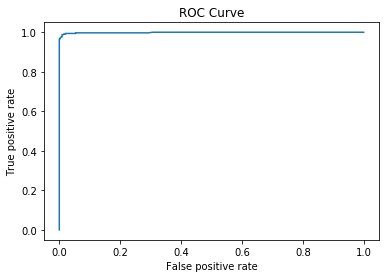

In [26]:
x_val = []
y_val = []
vals = np.zeros(validation_X.shape[0])
for i in range(validation_X.shape[0]) :
    vals[i] = objective_function(train_X, train_Y, alpha, b, kernel_RBF, validation_X[i])
for n in np.linspace(-5, 5, 1000) :
    tp, fp, fn, tn = 0, 0, 0, 0
    for i in range(validation_X.shape[0]) :
        val = vals[i]
        if(val >= n) :
            if(validation_Y[i] == 1) :
                tp += 1
            else :
                fp += 1
        else :
            if(validation_Y[i] == 1) :
                fn += 1
            else :
                tn += 1  
    tpr = float(tp) / float(tp + fn)
    fpr = float(fp) / float(fp + tn)
    x_val.append(fpr)
    y_val.append(tpr)
x_val.reverse()
y_val.reverse()
plt.plot(x_val, y_val)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")